# Run Gradient Optimisation for Feature Selection on Water Dataset

In [1]:
import pathlib
import re

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from ase.io import read as ase_read

from dadapy.feature_weighting import FeatureWeighting

/Users/fwodaczek/miniforge3/envs/dii_ms/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Import Data

Large SOAP datasets and especially ACSFs are somewhat slow to calculate, so I mostly just run this on our local cluster and then load from numpy files.
To recalculate the descriptors, use `make_descriptors.py`.

In [2]:
data_dir = pathlib.Path("./data").resolve()

In [3]:
# Get ase.Atoms objects for each liquid configuration
liquid_frames = ase_read(data_dir.joinpath("ice_and_water_data/dataset_1000_eVAng.xyz"), index=':')
n_atoms = np.sum(np.asarray([len(frame) for frame in liquid_frames], dtype=np.int16))
atom_types = np.zeros((n_atoms), dtype=np.int8)

# Collect some metadata, like how many atoms/config, atoms in total and which atom is even an oxygen.
counter = 0
for frame in liquid_frames:
    atom_types[counter:counter+len(frame)] = frame.get_atomic_numbers()
    counter+=len(frame)
is_o = atom_types==8
is_h = np.logical_not(is_o)

print(f"Found {np.count_nonzero(is_o)} Oxygen atoms and {np.count_nonzero(is_h)} Hydrogen atoms.")

Found 64000 Oxygen atoms and 128000 Hydrogen atoms.


In [4]:
# Get new descriptors from file or laod ase.Atoms objects and recalculate
# Recalculation here works best when just getting SOAPs, ACSF takes a little long
average_soap = np.load(data_dir.joinpath("water_phase_store/average_soap_rcut6_nmax6_lmax6_sigma03.npy"))
atomic_soap = np.load(data_dir.joinpath("water_phase_store/singleatom_soap_rcut6_nmax6_lmax6_sigma03.npy"))
print("Fetched computed atomic SOAP descriptors for %u configurations and with %u features each."%atomic_soap.shape)
print("Fetched computed global SOAP descriptors for %u configurations and with %u features each."%average_soap.shape)

# The file format of the input file the descriptors are calculated from is 54 solid, 1000 liquid
# So we can just get the liquid configurations by getting the number of atoms n_atoms in the liquid configurations
# From the end of the decriptor matrix
liquid_atomic_soap = atomic_soap[-n_atoms:, :].copy()

Fetched computed atomic SOAP descriptors for 194847 configurations and with 546 features each.
Fetched computed global SOAP descriptors for 1054 configurations and with 546 features each.


In [5]:
average_acsf = np.asarray(np.load(data_dir.joinpath("water_phase_store/average_acsf_rcut6_gridsearch_bohr_lambda.npy")), dtype=np.float32)
atomic_acsf = np.asarray(np.load(data_dir.joinpath("water_phase_store/singleatom_acsf_rcut6_gridsearch_bohr_lambda.npy")), dtype=np.float32)
liquid_atomic_acsf = atomic_acsf[-n_atoms:, :].copy()
print("Fetched computed atomic SOAP descriptors for %u configurations and with %u features each."%atomic_acsf.shape)
print("Fetched computed liquid atomic SOAP descriptors for %u configurations and with %u features each."%liquid_atomic_acsf.shape)
print("Fetched computed global SOAP descriptors for %u configurations and with %u features each."%average_acsf.shape)

Fetched computed atomic SOAP descriptors for 194847 configurations and with 176 features each.
Fetched computed liquid atomic SOAP descriptors for 192000 configurations and with 176 features each.
Fetched computed global SOAP descriptors for 1054 configurations and with 176 features each.


### Post Processing of Input Data

In [6]:
descriptors = [average_soap, atomic_soap, liquid_atomic_soap, average_acsf, atomic_acsf, liquid_atomic_acsf]
for desc in descriptors:
    desc /= np.linalg.norm(desc, axis=-1)[:, np.newaxis]
average_soap, atomic_soap, liquid_atomic_soap, average_acsf, atomic_acsf, liquid_atomic_acsf = descriptors

# apparently atomic acsf sometimes become nan, set to 0
nan_frames = np.argwhere(np.isnan(atomic_acsf))[:, 0]
print("Removing %u nan frames in atomic acsf"%(len(np.unique(nan_frames))))
atomic_acsf[nan_frames, :] = 0.

nan_frames = np.argwhere(np.isnan(liquid_atomic_acsf))[:, 0]
print("Removing %u nan frames in liquid atomic acsf"%(len(np.unique(nan_frames))))
liquid_atomic_acsf[nan_frames, :] = 0.

Removing 13 nan frames in atomic acsf
Removing 13 nan frames in liquid atomic acsf


/var/folders/nq/1pvrqp497rscsl8hwd4jr5cw0000gn/T/ipykernel_5126/1193764207.py:3: RuntimeWarning: invalid value encountered in divide
  desc /= np.linalg.norm(desc, axis=-1)[:, np.newaxis]


### Defining Input and Target Data

`target_data` is the space which delivers the target ranks, `input_space` is the space for which the gammas should be optimised.

In [7]:
rng = np.random.default_rng()
# random_selection = rng.choice(liquid_atomic_soap.shape[0], 300)
target_data = liquid_atomic_soap[::500]
input_space = liquid_atomic_acsf[::500]

fw_input = FeatureWeighting(coordinates=input_space, maxk=input_space.shape[0]-1, verbose=True)
fw_target = FeatureWeighting(coordinates=target_data, maxk=target_data.shape[0]-1, verbose=True)

if True:
    stds = np.std(input_space, axis=0)
    stds[stds==0.] = 1.
    standardised_input = input_space/stds[np.newaxis, :]
    # dist_matrix = kimb.compute_dist_matrix(data=target_data.astype(np.double), period=np.zeros((target_data.shape[-1])))
    # truth_ranks = stats.rankdata(dist_matrix, method='average', axis=1).astype(int, copy=False)

print(f"Working on ground truth shaped {target_data.shape} and optimising space of shape {input_space.shape}")

Working on ground truth shaped (384, 546) and optimising space of shape (384, 176)


## Feature Selection

Skip this section and head to "Evaluations and Plotting" where you can load pre-generated descriptors and kernel imbalances used in the publication.

### Lasso Optimisation

#### Find Optimal Learning Rate

In [8]:
initial_gammas = np.ones((input_space.shape[-1],), dtype=np.double)
lr_list = np.logspace(-2, 2, 10)

opt_l_rate = fw_input.return_optimal_learning_rate(
    target_data=fw_target, initial_weights=initial_gammas, lambd=None, 
    n_epochs=50, decaying_lr="exp", 
    n_samples=154, trial_learning_rates=lr_list,
)

kernel_imbalances_list = fw_input.history['dii_per_epoch_per_lr'][np.argwhere(opt_l_rate==lr_list)[0, 0], :]

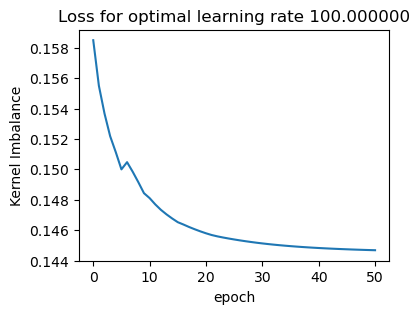

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

ax.plot(kernel_imbalances_list, label="kernel imbalances")

ax.set_title("Loss for optimal learning rate %f"%opt_l_rate)
# ax.set_yscale('log')
ax.set_ylabel('Kernel Imbalance')
ax.set_xlabel("epoch")

plt.show()

#### Optimise using Lasso Regularisation

10 l1-penalties to test:
optimization with l1-penalty 1 of strength 0 took: 12.30 s.
optimization with l1-penalty 2 of strength 1e-05 took: 9.53 s.
optimization with l1-penalty 3 of strength 3.162e-05 took: 9.15 s.
optimization with l1-penalty 4 of strength 0.0001 took: 9.34 s.
optimization with l1-penalty 5 of strength 0.0003162 took: 4.19 s.
optimization with l1-penalty 6 of strength 0.001 took: 2.55 s.
optimization with l1-penalty 7 of strength 0.003162 took: 1.42 s.
optimization with l1-penalty 8 of strength 0.01 took: 1.00 s.
optimization with l1-penalty 9 of strength 0.03162 took: 0.13 s.


/Users/fwodaczek/miniforge3/envs/dii_ms/lib/python3.9/site-packages/dadapy/_utils/differentiable_imbalance.py:540: UserWarning: The l1-regularization of 0.03162277660168379 is too high. All features would be set to 0. No full optimization possible
  warn(
/Users/fwodaczek/miniforge3/envs/dii_ms/lib/python3.9/site-packages/dadapy/_utils/differentiable_imbalance.py:540: UserWarning: The l1-regularization of 0.1 is too high. All features would be set to 0. No full optimization possible
  warn(


optimization with l1-penalty 10 of strength 0.1 took: 0.12 s.
in intercollation  1  of  6 for test l1  1  of  68 , the time was:  10.279795169830322
in intercollation  1  of  6 for test l1  2  of  68 , the time was:  10.633110046386719
in intercollation  1  of  6 for test l1  3  of  68 , the time was:  10.288098096847534
in intercollation  1  of  6 for test l1  4  of  68 , the time was:  10.279135942459106
in intercollation  1  of  6 for test l1  5  of  68 , the time was:  10.146392822265625
in intercollation  1  of  6 for test l1  6  of  68 , the time was:  9.962342739105225
in intercollation  1  of  6 for test l1  7  of  68 , the time was:  10.596655130386353
in intercollation  1  of  6 for test l1  8  of  68 , the time was:  10.820199251174927
in intercollation  1  of  6 for test l1  9  of  68 , the time was:  9.92143201828003
in intercollation  1  of  6 for test l1  10  of  68 , the time was:  10.013976097106934
in intercollation  1  of  6 for test l1  11  of  68 , the time was:  9

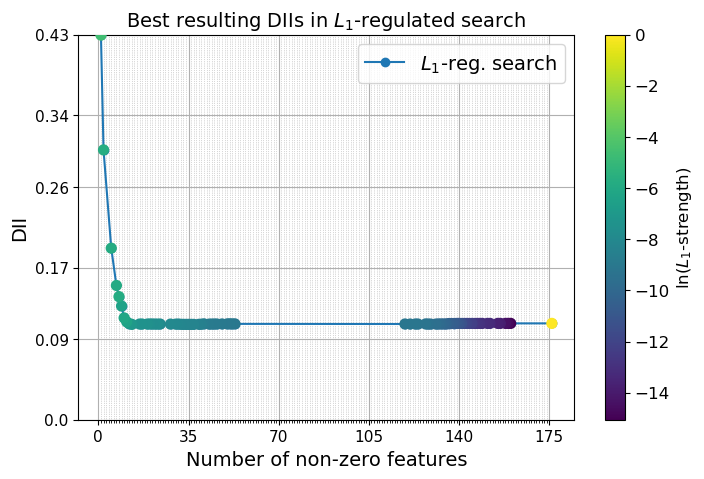

In [10]:
(
    num_nonzero_features,
    l1_penalties_opt_per_nfeatures,
    dii_opt_per_nfeatures, 
    weights_opt_per_nfeatures
) = fw_input.return_lasso_optimization_dii_search(
    target_data=fw_target, initial_weights=initial_gammas, lambd=None, 
    learning_rate=opt_l_rate, constrain=True, decaying_lr="exp",
    n_epochs=100, refine=True
)

#### Post Processing Gammas from Lasso Optimisation

The weights returned by lasso optimisation are returned unordered.
This recalculates the information imbalance for each entry and orders the weights by number of non-zero features and best information imbalance.

In [11]:
# invert order so it has least features first
kernel_imbs = dii_opt_per_nfeatures[::-1]
lasso_gammas = weights_opt_per_nfeatures[::-1]
num_nonzero_features = num_nonzero_features[::-1]
l1_penalties_opt_per_nfeatures = l1_penalties_opt_per_nfeatures[::-1]

### Weighted Backwards Greedy

In [12]:
greedy_imbs, greedy_gammas = fw_input.return_backward_greedy_dii_elimination(
    target_data=fw_target, initial_weights=initial_gammas,
    lambd=None, n_epochs=80,
    constrain=False, decaying_lr="exp",
)

number of nonzero weights: 176, execution time: 8.44 s.
number of nonzero weights: 175, execution time: 8.42 s.
number of nonzero weights: 174, execution time: 8.35 s.
number of nonzero weights: 173, execution time: 8.43 s.
number of nonzero weights: 172, execution time: 8.23 s.
number of nonzero weights: 171, execution time: 9.72 s.
number of nonzero weights: 170, execution time: 8.75 s.
number of nonzero weights: 169, execution time: 8.44 s.
number of nonzero weights: 168, execution time: 8.37 s.
number of nonzero weights: 167, execution time: 8.34 s.
number of nonzero weights: 166, execution time: 8.41 s.
number of nonzero weights: 165, execution time: 8.23 s.
number of nonzero weights: 164, execution time: 8.20 s.
number of nonzero weights: 163, execution time: 8.13 s.
number of nonzero weights: 162, execution time: 8.04 s.
number of nonzero weights: 161, execution time: 8.28 s.
number of nonzero weights: 160, execution time: 8.16 s.
number of nonzero weights: 159, execution time: 

## Evaluations and Plotting

If no recalculations are needed just go to this part and run it.

In [13]:
mode='load_old'
if mode=='load_old':
    # make a subdirectory for storing results
    if not data_dir.joinpath('water_phase_store').exists():
        data_dir.joinpath('water_phase_store').mkdir()

    np.save(data_dir.joinpath('water_phase_store/kernel_imbs_hartbohr_lambda.npy'), kernel_imbs, allow_pickle=False)
    np.save(data_dir.joinpath('water_phase_store/lasso_gammas_hartbohr_lambda.npy'), lasso_gammas, allow_pickle=False)
    np.save(data_dir.joinpath("water_phase_store/greedy_gammas_hartbohr_lambda.npy"), greedy_gammas, allow_pickle=False)
    np.save(data_dir.joinpath("water_phase_store/greedy_imbs_hartbohr_lambda.npy"), greedy_imbs, allow_pickle=False)
elif mode=='load_old':
    kernel_imbs = np.load(data_dir.joinpath('water_phase_store/kernel_imbs_hartbohr_lambda.npy'))
    lasso_gammas = np.load(data_dir.joinpath('water_phase_store/lasso_gammas_hartbohr_lambda.npy'))
    greedy_gammas = np.load(data_dir.joinpath("water_phase_store/greedy_gammas_hartbohr_lambda.npy"))
    greedy_imbs = np.load(data_dir.joinpath("water_phase_store/greedy_imbs_hartbohr_lambda.npy"))

where_gammas_found = np.logical_and(kernel_imbs!=0., np.logical_not(np.isnan(kernel_imbs)))

# in old formats, greedy gammas is sometimes saved with history:
if len(greedy_gammas.shape)>2:
    greedy_gammas = greedy_gammas[:, -1, :].copy()
if len(greedy_imbs.shape)>1:
    greedy_imbs = greedy_imbs[:, -1].copy()

In [14]:
n_batches = 10
rng = np.random.default_rng()
batch_indices = rng.choice(liquid_atomic_soap.shape[0], size=(n_batches, input_space.shape[0]), replace=False)

true_fws = []
for batch in batch_indices:
    true_fws.append(FeatureWeighting(
        coordinates=liquid_atomic_soap[batch, :], maxk=len(batch)-1, verbose=False
    ))

print("Kernel Imbalance")
batched_lasso_imbalances = np.empty((len(kernel_imbs), n_batches), dtype=np.float32)
for n_dims in range(len(kernel_imbs)):
    if where_gammas_found[n_dims]:
        for ii_batch, batch in enumerate(batch_indices):
            batched_lasso_imbalances[n_dims, ii_batch] = FeatureWeighting(
                coordinates=liquid_atomic_acsf[batch, :]*lasso_gammas[n_dims, :], maxk=len(batch)-1, verbose=False
            ).return_dii(
                target_data=true_fws[ii_batch],
                lambd=None
            )

print("Greedy Imbalance")
batched_greedy_imbalances = np.empty((len(greedy_imbs), n_batches), dtype=np.float32)
for n_dims in range(greedy_gammas.shape[-1]):
    for ii_batch, batch in enumerate(batch_indices):
        batched_greedy_imbalances[n_dims, ii_batch] = FeatureWeighting(
            coordinates=liquid_atomic_acsf[batch, :]*greedy_gammas[n_dims, :], 
            maxk=len(batch)-1, verbose=False,
        ).return_dii(
            target_data=true_fws[ii_batch],
            lambd=None
        )

Kernel Imbalance
Greedy Imbalance


In [15]:
print("Random Selection")
batched_random_imbalances = np.empty((len(kernel_imbs), n_batches), dtype=np.float32)
rand_gamma_mask = np.zeros((input_space.shape[-1], ), dtype=bool)
for n_dims in range(1, len(kernel_imbs)):
    for ii_batch, batch in enumerate(batch_indices):
        rand_gamma_mask[:] = False
        rand_gamma_mask[rng.choice(input_space.shape[-1], size=(n_dims, ), replace=False)] = True
        batched_random_imbalances[n_dims, ii_batch] = FeatureWeighting(
            coordinates=(liquid_atomic_acsf[batch, :]/stds)[:, rand_gamma_mask], 
            maxk=len(batch)-1, verbose=False,
        ).return_dii(
            target_data=true_fws[ii_batch],
            lambd=None
        )

Random Selection


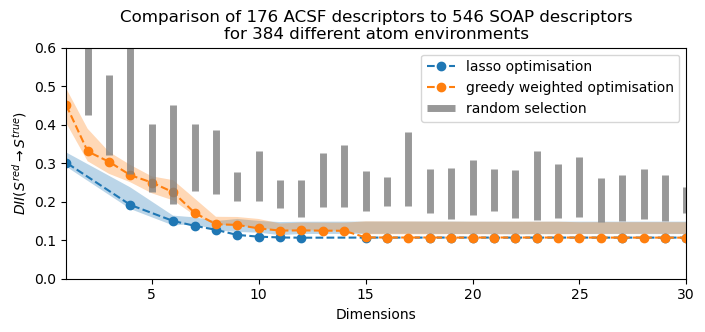

In [16]:
plt.rcParams.update(plt.rcParamsDefault)

fig, ax = plt.subplots(1, 1, figsize=(8, 3))

if False:
    ax.plot(range(1, len(classic_greedy_imbalances)+1), classic_greedy_imbalances[::-1], 'x--', label='classic greedy')
    ax.fill_between(
        range(1, len(classic_greedy_imbalances)+1), 
        np.min(batched_classic_imbalances[::-1, :], axis=1),
        np.max(batched_classic_imbalances[::-1, :], axis=1),
        alpha=0.3, linewidth=10
    )
    ax.plot(
    np.arange(1, greedy_select_imbalance.shape[0]+1), greedy_select_imbalance[::-1],
    'o--', label='greedy select'
    )

ax.plot(
    np.arange(kernel_imbs.shape[0])[where_gammas_found], kernel_imbs[where_gammas_found],
    'o--', label='lasso optimisation'
)
ax.fill_between(
    np.arange(kernel_imbs.shape[0])[where_gammas_found], 
    np.min(batched_lasso_imbalances[where_gammas_found, :], axis=1),
    np.max(batched_lasso_imbalances[where_gammas_found, :], axis=1),
    alpha=0.3
)

ax.plot(
    np.arange(1, greedy_imbs.shape[0]+1), greedy_imbs[::-1],
    'o--', label='greedy weighted optimisation'
)
ax.fill_between(
    range(1, len(batched_greedy_imbalances)+1), 
    np.min(batched_greedy_imbalances[::-1, :], axis=1),
    np.max(batched_greedy_imbalances[::-1, :], axis=1),
    alpha=0.3, linewidth=10
)

ax.vlines(
    np.arange(1, kernel_imbs.shape[0]+1), 
    np.min(batched_random_imbalances, axis=1),
    np.max(batched_random_imbalances, axis=1),
    alpha=0.8, color='tab:grey', linewidth=5, label='random selection'
)

ax.set_xlabel('Dimensions')
ax.set_ylabel(r'$DII(S^{red} \to S^{true})$')
ax.set_title("Comparison of %u ACSF descriptors to %u SOAP descriptors\nfor %u different atom environments"%(input_space.shape[1], target_data.shape[-1], input_space.shape[0]))
ax.legend()
ax.set_ylim([0., 0.6])
ax.set_xlim([1, 30])

fig.savefig("ii_history_acsf%u_c%u.png"%input_space.shape[::-1], format='png', bbox_inches='tight', dpi=300)
plt.show()

### Final Figure

#### Get Runtimes and RMSEs

In [17]:
from glob import glob
import re

target_dir = data_dir.joinpath("mlp_prediction")

results_dict = {}
for logfile in target_dir.joinpath('errorbar_logs').glob('*.log'):
    with open(logfile, 'r') as f:
        content = f.read()
        # this is what the mlps were called and how they can be identified in this context
        runtype = re.search("231213_pot_acsf(.*)_hartbohr_scaleunits_bcdata_lambda", content).group(1)
        run_num = re.search("run_([0-9]*)", content).group(1)

        # memory_kb = re.search("\s([0-9]*)maxresident", content).group(1)
        runtime_s = re.search("user\s0m([0-9]*\.[0-9]*)", content).group(1)
        
        pot_dir = target_dir.joinpath("mlps/pot_acsf"+runtype+"/run_"+run_num)

        all_errors = np.loadtxt(pot_dir.joinpath('learning-curve.out'))
        all_errors[:, 1:9] *= 27.211386245988
        all_errors[:, 9:13] *= 51.421 # Hartree/Bohr to eV/Angstrom conversion
        rmse_ftest_evA = all_errors[-1, 12]
        
        if runtype not in results_dict:
            results_dict[runtype] = {"runtimes": [], "rmses": []}
        
        results_dict[runtype]["runtimes"].append(float(runtime_s))
        results_dict[runtype]["rmses"].append(rmse_ftest_evA) 
print(results_dict)

{'25rand': {'runtimes': [0.177, 0.178, 0.195, 0.185, 0.184, 0.188], 'rmses': [0.15498068855331, 0.1585097421217, 0.15711579491478, 0.15082969747570998, 0.16089489235145002, 0.14923728166351]}, '176': {'runtimes': [0.721, 0.735, 0.743, 0.734, 0.745, 0.732], 'rmses': [0.06438361242011001, 0.07434160890873, 0.07494234245438, 0.07362550617906, 0.07498923737796, 0.06619304182124]}, '50rand': {'runtimes': [0.283, 0.285, 0.274, 0.294, 0.293, 0.289], 'rmses': [0.07382104687260001, 0.07560770499809, 0.06758101802164, 0.07145750271863001, 0.06919681804780001, 0.08061049419647]}, '18rand': {'runtimes': [0.146, 0.15, 0.149, 0.145, 0.135, 0.151], 'rmses': [0.14739327421093001, 0.12943319415173, 0.12436699257615, 0.13128229948225, 0.13334522670023, 0.13926380693968]}, '50': {'runtimes': [0.223, 0.221, 0.219, 0.23, 0.223, 0.209], 'rmses': [0.08605883556143999, 0.06243276138531, 0.07266546222539, 0.07414137244947, 0.06835479814438, 0.07446735793581]}, '10rand': {'runtimes': [0.136, 0.125, 0.132, 0.132

#### Make Final Plot

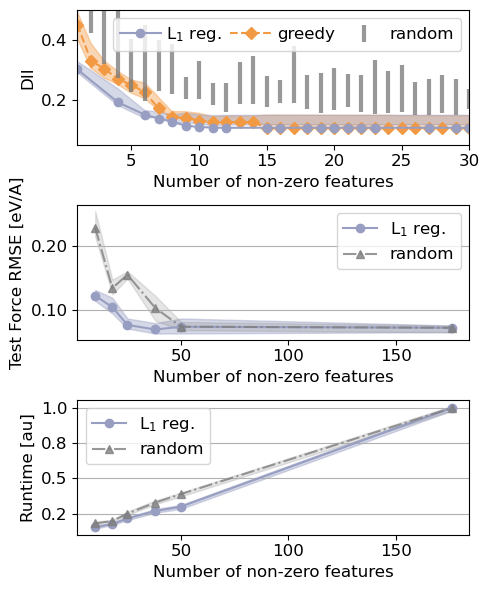

In [18]:
from matplotlib.lines import Line2D
from matplotlib.ticker import StrMethodFormatter

plt.rcParams.update(plt.rcParamsDefault)
fontsize = 12

if False:
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "Helvetica",
        "font.size": fontsize,
        'text.latex.preamble': r'\usepackage{amsmath}'
    })

double_ax = False

fig, axes = plt.subplots(3, 1, figsize=(5, 6))

kernel_keys = ['10', '18', '25', '38', '50', '176']
rand_keys = ['10rand', '18rand', '25rand', '38rand', '50rand', '176']

cmap = plt.get_cmap('viridis')

greedy_dii_color = "#f29944" # cmap(0.6)
lasso_dii_color = "#989ec1" # cmap(0.3)
random_dii_color = "tab:grey"

mae_ax = axes[1]

mae_ax.plot(
    [int(kernel_key) for kernel_key in kernel_keys],
    [np.mean(results_dict[kernel_key]["rmses"]) for kernel_key in kernel_keys],
    label=r'L$_1$ reg.', color=lasso_dii_color, marker='o', linestyle='-'
)
mae_ax.fill_between(
    [int(kernel_key) for kernel_key in kernel_keys],
    [np.min(results_dict[kernel_key]["rmses"]) for kernel_key in kernel_keys],
    [np.max(results_dict[kernel_key]["rmses"]) for kernel_key in kernel_keys],
    alpha=0.4, color=lasso_dii_color
)
mae_ax.plot(
    [int(kernel_key) for kernel_key in kernel_keys],
    [np.mean(results_dict[rand_keys]["rmses"]) for rand_keys in rand_keys],
    label='random', color=random_dii_color, marker='^', linestyle='-.', alpha=0.8
)
mae_ax.fill_between(
    [int(kernel_key) for kernel_key in kernel_keys],
    [np.min(results_dict[rand_keys]["rmses"]) for rand_keys in rand_keys],
    [np.max(results_dict[rand_keys]["rmses"]) for rand_keys in rand_keys],
    alpha=0.2, color=random_dii_color
)
mae_ax.set_xlabel("Number of non-zero features", fontsize=fontsize)
mae_ax.set_ylabel("Test Force RMSE [eV/A]", fontsize=fontsize)
mae_ax.tick_params(axis='x', which='both', labelsize=fontsize)
mae_ax.tick_params(axis='y', which='both', labelsize=fontsize)
mae_ax.grid(axis='y')
mae_ax.legend(fontsize=fontsize)

time_ax = axes[2]

kernel_times = np.array([np.mean(results_dict[kernel_key]["runtimes"]) for kernel_key in kernel_keys])
kernel_uppers = np.array([np.max(results_dict[kernel_key]["runtimes"]) for kernel_key in kernel_keys])
kernel_lowers = np.array([np.min(results_dict[kernel_key]["runtimes"]) for kernel_key in kernel_keys])
random_times = np.array([np.mean(results_dict[rand_keys]["runtimes"]) for rand_keys in rand_keys])
random_uppers = np.array([np.max(results_dict[rand_keys]["runtimes"]) for rand_keys in rand_keys])
random_lowers = np.array([np.min(results_dict[rand_keys]["runtimes"]) for rand_keys in rand_keys])

max_time = np.max(np.concatenate([kernel_times, random_times]))
time_ax.plot(
    [int(kernel_key) for kernel_key in kernel_keys], 
    kernel_times/max_time,
    label=r'L$_1$ reg.', color=lasso_dii_color, marker='o', linestyle='-'
)
time_ax.plot(
    [int(kernel_key) for kernel_key in kernel_keys], 
    random_times/max_time,
    label='random', color=random_dii_color, marker='^', linestyle='-.', alpha=0.8
)
time_ax.fill_between(
    [int(kernel_key) for kernel_key in kernel_keys],
    kernel_lowers/max_time,
    kernel_uppers/max_time,
    alpha=0.4, color=lasso_dii_color
)
time_ax.fill_between(
    [int(kernel_key) for kernel_key in kernel_keys],
    random_lowers/max_time,
    random_uppers/max_time,
    alpha=0.2, color=random_dii_color
)
time_ax.set_xlabel("Number of non-zero features", fontsize=fontsize)
time_ax.set_ylabel("Runtime [au]", fontsize=fontsize)
time_ax.tick_params(axis='x', which='both', labelsize=fontsize)
time_ax.tick_params(axis='y', which='both', left=True, labelleft=True, labelsize=fontsize)
time_ax.grid(axis='y')
time_ax.legend(fontsize=fontsize)

dii_ax = axes[0]

dii_ax.plot(
    np.arange(1, greedy_imbs.shape[0]+1), greedy_imbs[::-1],
    'D--', label='greedy weighted optimisation', color=greedy_dii_color
)
dii_ax.fill_between(
    range(1, len(batched_greedy_imbalances)+1), 
    np.min(batched_greedy_imbalances[::-1, :], axis=1),
    np.max(batched_greedy_imbalances[::-1, :], axis=1),
    alpha=0.4, color=greedy_dii_color,
)

dii_ax.plot(
    np.arange(kernel_imbs.shape[0])[where_gammas_found], kernel_imbs[where_gammas_found],
    'o-', label='lasso optimisation', color=lasso_dii_color
)
dii_ax.fill_between(
    np.arange(kernel_imbs.shape[0])[where_gammas_found], 
    np.min(batched_lasso_imbalances[where_gammas_found, :], axis=1),
    np.max(batched_lasso_imbalances[where_gammas_found, :], axis=1),
    alpha=0.4, color=lasso_dii_color,
)

if False:
    dii_ax.plot(
        np.arange(1, kernel_imbs.shape[0]+1), 
        np.min(batched_random_imbalances, axis=1),
        '^', alpha=0.8, color=random_dii_color,
    )
    dii_ax.plot(
        np.arange(1, kernel_imbs.shape[0]+1), 
        np.max(batched_random_imbalances, axis=1),
        '^', alpha=0.8, color=random_dii_color,
    )
dii_ax.vlines(
    np.arange(1, kernel_imbs.shape[0]+1), 
    np.min(batched_random_imbalances, axis=1),
    np.max(batched_random_imbalances, axis=1),
    alpha=0.8, color=random_dii_color, linewidth=3,
    # linestyle='--'
)

# dii_ax.set_xlabel('Number of non-zero features', fontsize=fontsize)
dii_ax.set_ylabel("DII", fontsize=fontsize)
dii_ax.tick_params(
    axis='x', which='both', labelsize=fontsize, 
    bottom=True, labelbottom=True, top=False, labeltop=False
)
dii_ax.tick_params(axis='y', which='both', labelsize=fontsize)
dii_ax.set_xlabel("Number of non-zero features", fontsize=fontsize)
dii_ax.set_ylim([0.05, 0.5])
dii_ax.set_xlim([1, 30])

dii_ax.legend(
    handles=[
        Line2D([-1], [-1], marker='o', linestyle='-', color=lasso_dii_color, label=r'L$_1$ reg.'),
        Line2D([-1], [-1], marker='D', linestyle='--', color=greedy_dii_color, label='greedy'),
        dii_ax.errorbar([-1], [-1], yerr=0, marker='', elinewidth=3, linestyle='', color=random_dii_color, label='random', alpha=0.8),
    ],
    ncols=3, columnspacing=0.5, handletextpad=0.3, handlelength=2.5,
    fontsize=fontsize
)

mae_ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0f}"))
mae_ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.2f}"))
time_ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0f}"))
time_ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.1f}"))

dii_ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0f}"))
dii_ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.1f}"))
plt.tight_layout()

fig.savefig("waterphase_final.pdf", format='pdf', bbox_inches='tight')
plt.show()

#### Extract Plotted Data

In [19]:
figa_data = np.empty((kernel_imbs.shape[0]-1, 9), dtype=np.float32)
nfeat_indices = range(1, len(figa_data)+1)

figa_data[:, 0] = nfeat_indices
figa_data[:, 1] = kernel_imbs[:][1:]
figa_data[:, 2] = np.min(batched_lasso_imbalances[:, :], axis=1)[1:]
figa_data[:, 3] = np.max(batched_lasso_imbalances[:, :], axis=1)[1:]

figa_data[:, 4] = greedy_imbs[::-1][:-1]
figa_data[:, 5] = np.min(batched_greedy_imbalances[::-1, :], axis=1)[:-1]
figa_data[:, 6] = np.max(batched_greedy_imbalances[::-1, :], axis=1)[:-1]

figa_data[:, 7] = np.min(batched_random_imbalances, axis=1)[1:]
figa_data[:, 8] = np.max(batched_random_imbalances, axis=1)[1:]

figa_data[np.logical_not(where_gammas_found[1:]), 1:4] = np.nan

np.savetxt(
    "fig3a_data.csv", figa_data, delimiter=',', 
    fmt="%u %.6e %.6e %.6e %.6e %.6e %.6e %.6e %.6e",
    header="n_features lasso_dii lasso_min_dii lasso_max_dii greedy_dii greedy_mi_dii greedy_max_dii random_dii random_min_dii random_max_dii"
)

figb_data = np.empty((len(kernel_keys), 7), dtype=np.float32)
figb_indices = np.array([int(kernel_key) for kernel_key in kernel_keys], dtype=int)

figb_data[:, 0] = figb_indices
for ii_key, kernel_key in enumerate(kernel_keys):
    figb_data[ii_key, 1] = np.mean(results_dict[kernel_key]["rmses"])
    figb_data[ii_key, 2] = np.min(results_dict[kernel_key]["rmses"])
    figb_data[ii_key, 3] = np.max(results_dict[kernel_key]["rmses"])

for ii_key, rand_key in enumerate(rand_keys):
    figb_data[ii_key, 4] = np.mean(results_dict[rand_key]["rmses"])
    figb_data[ii_key, 5] = np.min(results_dict[rand_key]["rmses"])
    figb_data[ii_key, 6] = np.max(results_dict[rand_key]["rmses"])

np.savetxt(
    "fig3b_data.csv", figb_data, delimiter=',', 
    fmt="%u %.6e %.6e %.6e %.6e %.6e %.6e",
    header="n_features lasso_mean[eV\A] lasso_min[eV\A] lasso_max[eV\A] random[eV\A] random_min[eV\A] random_max[eV\A]"
)

figc_data = np.empty((len(kernel_keys), 7), dtype=np.float32)
figc_indices = np.array([int(kernel_key) for kernel_key in kernel_keys], dtype=int)

figc_data[:, 0] = figc_indices
for ii_key, kernel_key in enumerate(kernel_keys):
    figc_data[ii_key, 1] = np.mean(results_dict[kernel_key]["runtimes"])
    figc_data[ii_key, 2] = np.min(results_dict[kernel_key]["runtimes"])
    figc_data[ii_key, 3] = np.max(results_dict[kernel_key]["runtimes"])

for ii_key, rand_key in enumerate(rand_keys):
    figc_data[ii_key, 4] = np.mean(results_dict[rand_key]["runtimes"])
    figc_data[ii_key, 5] = np.min(results_dict[rand_key]["runtimes"])
    figc_data[ii_key, 6] = np.max(results_dict[rand_key]["runtimes"])

np.savetxt(
    "fig3c_data.csv", figc_data, delimiter=',', 
    fmt="%u %.6e %.6e %.6e %.6e %.6e %.6e",
    header="n_features lasso_mean[s] lasso_min[s] lasso_max[s] random[s] random_min[s] random_max[s]"
)